# Sentiment analysis using IMDB dataset

In [19]:
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn import svm
import zipfile
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from scipy import sparse
import nltk
import lime

# Download any necessary nltk files for nlp
nltk.download('punkt')

# Get data

In [3]:
zip_file_path = './data/imdb_dataset.zip'
extract_dir = './data/'
data_dir = 'imdb_dataset'

In [4]:
# Extract all the files 
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

## Data Processing & Cleaning

Let's begin by reading in all of our text files. We'll create their label according to their sentiment, either positive or negative. In addition we'll preprocess all the nexts by removing all non-alpha numeric characters. 

In [5]:
# Regex to remove all Non-Alpha Numeric 
SPECIAL_CHARS = re.compile(r'([^a-z\d!?.\s])', re.IGNORECASE)

def read_texts(glob_to_texts):
    texts = []
    labels = []
    label = int("pos" in glob_to_texts)
    for text_name in tqdm(glob(glob_to_texts)):
        with open(text_name, 'r') as text:
            # Removing all non-alphanumeric
            filter_text = SPECIAL_CHARS.sub('',  text.read())
            texts.append(filter_text)
            labels.append(label)
    return texts, labels

# Get all training data
train_pos_data = read_texts(os.path.join(data_dir, "train/pos/*.txt"))
train_neg_data = read_texts(os.path.join(data_dir, "train/neg/*.txt"))

# Get all test data
test_pos_data = read_texts(os.path.join(data_dir, "test/pos/*.txt"))
test_neg_data = read_texts(os.path.join(data_dir, "test/neg/*.txt"))

train_texts = train_pos_data[0] + train_neg_data[0]
train_labels = train_pos_data[1] + train_neg_data[1]

test_texts = test_pos_data[0] + test_neg_data[0]
test_labels = test_pos_data[1] + test_neg_data[1]

100%|██████████| 12500/12500 [00:00<00:00, 20140.15it/s]


## Sample Texts

Before we dive into actually building a model, let's take a look at our data. What does a positive example look like, and what does a negative example look like?

In [6]:
train_pos_sample_ind = np.random.randint(len(train_pos_data[0]))
train_neg_sample_ind = np.random.randint(len(train_neg_data[0]))

print("Positive Sentiment example")
print(train_pos_data[0][train_pos_sample_ind])
print("---------------------------")
print("Negative Sentiment example")
print(train_neg_data[0][train_neg_sample_ind])

Positive Sentiment example
This is one of my favourite martial arts movies from Hong Kong. It is one of John Woos earliest films and one of only a few traditional martial arts movies he directed. You can see his influences from working under Chang Cheh in this film. The action is good the fight choreography is conducted by Fong Hak On who appears as one of the bad guys in the movie. It stars Wei Pei of Five Venoms fame and a whole host of faces familiar to fans of Golden Harvest and Shaw Brothers productions. The story line is interesting there are a few decent plot twists and the build up of the characters and their relationships with each other is cleverly done. This film has only had a VHS release in the UK. Media Asia have released a region 3 DVD and there are versions of it on DVD available from the USA. The film is lovely to watch in either its original language or in its English dubbed version. I highly recommend this movie.
---------------------------
Negative Sentiment example

Split the data into training and validation sets. We'll create a validation test set with 10% of the data. 

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1,
                                                                    random_state=42)

We can also figure out the word frequencies from our dataset! The below code will count how frequent each word is in the dataset.

In [8]:
from collections import defaultdict

word_counts = defaultdict(int)

# Compute the frequency of each unique
for text in tqdm(train_texts + val_texts + test_texts):
    # Splits sentences 
    for word in word_tokenize(text):
        word_counts[word] += 1

100%|██████████| 50000/50000 [01:00<00:00, 821.64it/s]


In [18]:
print("100 Most frequent words")
for word in sorted(word_counts, reverse=True, key=lambda w: word_counts[w])[:100]:
    print(word, ":", word_counts[word])

100 Most frequent words
the : 572555
. : 464055
a : 308569
and : 307390
of : 284990
to : 263469
is : 208232
in : 172889
I : 143088
that : 132406
it : 129402
br : 120118
this : 120033
was : 94612
The : 88649
as : 84731
with : 84522
movie : 82646
for : 82464
film : 73666
but : 67998
on : 64518
are : 57626
not : 56836
have : 54601
his : 54509
you : 53835
be : 52321
! : 49164
one : 46411
at : 43261
by : 42797
he : 42732
an : 41316
all : 41050
who : 38857
from : 38596
like : 37546
its : 35987
they : 35587
so : 34132
or : 33799
about : 33497
her : 32916
just : 32726
has : 32698
? : 32338
out : 32303
This : 29190
some : 28447
good : 27463
more : 27144
very : 26330
... : 24888
what : 24275
up : 23951
would : 23759
It : 23746
can : 23382
when : 23090
time : 22826
if : 22763
which : 22509
really : 22236
only : 22055
their : 22030
see : 21812
were : 21772
had : 21681
even : 21542
story : 21449
there : 20943
no : 20929
my : 20586
me : 20269
she : 19301
than : 19107
much : 18412
been : 18202
get : 

## Vectorization
In order to extract information from text, we'll vectorize our word sequences. In other words, we'll transform our sentences into numerical features. There are many vectorization or embedding techniques such as Bag of Words, Pre-Trained word embeddings, but in our case we'll be using **TF-IDF**.

TF-IDF stands for "Term Frequency, Inverse Document Frequency". It's a technique that converts words into an importance score of each word in the document based on how they appear accros multiple documents. Intuitively, the TF-IDF score of a word is high when it is frequently found in a document. However, if the word appears in many documents, this word is not a unique identifier, and as such, will have a lower score. For example, common words such as "the" and "and" will have low score since they appear in many documents. 

Our TF-IDF vectorizer is a little more sophisticated than described above. It not only looks at the TF-IDF scores of individiual words, but also of **bigrams**, pairs of words that occur next to each other in our texts.

In [10]:
vec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize,
                      min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)

We fit our vectorizer to our entire corpus of words, which includes the training, validation, and test sets. Once fitted, we'll transform each subset of the data.

In [11]:
print("Created Vectorizer %s" % vec)
print("Fitting to all docs...")
vec.fit(train_texts + val_texts + test_texts)
print("Transforming train docs...")
trn_term_doc = vec.transform(train_texts)
print("Transforming val docs...")
val_term_doc = vec.transform(val_texts)
print("Transforming test docs...")
test_term_doc = vec.transform(test_texts)

Created Vectorizer TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words=None, strip_accents='unicode', sublinear_tf=1,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function word_tokenize at 0x7f819002b510>, use_idf=1,
        vocabulary=None)
Fitting to all docs...
Transforming train docs...
Transforming val docs...
Transforming test docs...


# Model

## Training our model
* First, we use a special kind of SVM model called a Naive-Bayes SVM model. It is based on the [sklearn.svm](http://scikit-learn.org/stable/modules/svm.html#svc) module to create a [vector classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).
* Next, we pass our training texts and labels to the classifier's fit method, which trains our model.
* Finally, the test texts and labels are passed to the score method to see how well we trained our model. This will return a float between 0-1 indicating our accuracy on the test data set

### Aside on SVM's (if you don't know what they are)
We have 2 colors of balls on the table that we want to separate.
![](http://i.imgur.com/zDBbD.png)

We get a stick and put it on the table, this works pretty well right?

![](http://i.imgur.com/aLZlG.png)

Some villain comes and places more balls on the table, it kind of works but one of the balls is on the wrong side and there is probably a better place to put the stick now. What a troll. 

![](http://i.imgur.com/kxWgh.png)

SVMs try to put the stick in the best possible place by having as big a gap on either side of the stick as possible. 

![](http://i.imgur.com/ePy4V.png)

Now when the villain returns, the stick is still in a pretty good spot.

![](http://i.imgur.com/BWYYZ.png)

There is another trick in the SVM toolbox that is even more important. Say the villain has seen how good you are with a stick so he gives you a new challenge.

![](http://i.imgur.com/R9967.png)

There’s no stick in the world that will let you split those balls well, so what do you do? You flip the table of course! Throwing the balls into the air. Then, with your pro ninja skills, you grab a sheet of paper and slip it between the balls.

![](http://i.imgur.com/WuxyO.png)

Now, looking at the balls from where the villain is standing, they balls will look split by some curvy line.

![](http://i.imgur.com/gWdPX.png)

Boring people the call balls data, the stick a classifier, the biggest gap trick optimization, call flipping the table kernelling and the piece of paper a hyperplane.

### But what is a Naive-Bayes SVM?

This SVM uses a simple, but clever kernelling trick. It transforms the input by multiplying it with a matrix that holds the log-probabilities of each feature (unigram, bigram, or trigram) being from a positive or negative example. This simple trick can boost the performance of the SVM to be on par with most state-of-the-art deep learning techniques (but this SVM can run on our measly computer)!

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual='auto', verbose=0):
        self.C = C
        self.dual = dual
        self.verbose = verbose
        self._clf = None
        print("Creating model with C=%s" % C)

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))
    
    def score(self, x, y):
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.score(x.multiply(self._r), y)
    
    def predict_proba(self, x):
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))
        
    def fit(self, x, y):
        # Check that X and y have correct shape
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y == y_i].sum(0)
            return (p + 1) / ((y == y_i).sum() + 1)

        self._r = sparse.csr_matrix(np.log(pr(x, 1, y) / pr(x, 0, y)))
        x_nb = x.multiply(self._r)
        if self.dual == 'auto':
            self.dual = x_nb.shape[0] <= x_nb.shape[1]
        self._clf = LogisticRegression(C=self.C, dual=self.dual, verbose=self.verbose)
        self._clf.fit(x_nb, y)
        return self

## Finding optimal parameters
We'll perform a grid search across the C parameter to find the optimal parameter for our dataset.

In [23]:
# Search for the appropriate C
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2]

best_model = None
best_val = -float("inf")
best_C = None
for C in Cs:
    print("Fitting with C={}".format(C))
    model = NbSvmClassifier(C=C, verbose=0).fit(trn_term_doc, train_labels)
    # Evaluate the model
    val_preds = model.predict(val_term_doc)
    score = np.mean(val_labels == val_preds)

    print("Model had val score of %s" % score)
    if score > best_val:
        print("New maximum score improved from {} to {}".format(best_val, score))
        best_model = model
        best_val = score
        best_C = C
score = best_val
print("Best score with C={} is {}".format(best_C, score))

Fitting with C=0.01
Creating model with C=0.01
Model had val score of 0.8532
New maximum score improved from -inf to 0.8532
Fitting with C=0.1
Creating model with C=0.1
Model had val score of 0.8596
New maximum score improved from 0.8532 to 0.8596
Fitting with C=1.0
Creating model with C=1.0
Model had val score of 0.8936
New maximum score improved from 0.8596 to 0.8936
Fitting with C=10.0
Creating model with C=10.0
Model had val score of 0.9148
New maximum score improved from 0.8936 to 0.9148
Fitting with C=100.0
Creating model with C=100.0
Model had val score of 0.9164
New maximum score improved from 0.9148 to 0.9164
Best score with C=100.0 is 0.9164


## Test score

In [24]:
best_model.score(test_term_doc, test_labels)

0.91308

## Takeaways
From this tutorial, we learned how to work with text data and use a basic embedding. In addition, we realize that deep learning isn't always the way to go! We trained a fast and powerful linear-ish model that achieved ~**91**%!

## Use LIME to Explain our predictions

In [26]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vec, best_model)

In [27]:
c.predict_proba([test_texts[0]])

array([[0.10215365, 0.89784635]])

In [32]:
from lime.lime_text import LimeTextExplainer
class_names = ["negative", "positive"]
explainer = LimeTextExplainer(class_names=class_names)

In [34]:
idx = 83
exp = explainer.explain_instance(test_texts[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(positive) =', c.predict_proba([test_texts[idx]])[0,1])
print('True class: %s' % class_names[test_labels[idx]])

/home/abhmul/.conda/envs/dl/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 83
Probability(positive) = 0.9973952074379704
True class: positive


In [35]:
exp.as_list()

[('810', 0.13494734271430656),
 ('favorite', 0.07177037644747612),
 ('hilarious', 0.041643969385283974),
 ('beautiful', 0.03616023364942977),
 ('easy', 0.031017250463696827),
 ('hoping', -0.027000732521257453)]

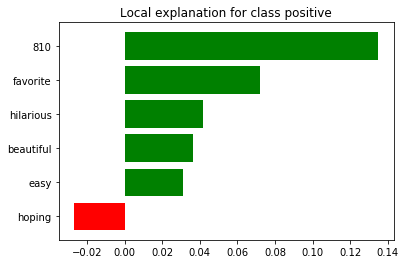

In [38]:
%matplotlib inline
fig = exp.as_pyplot_figure()